# Customer Revenue Prediction


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import collections
from sklearn.preprocessing import LabelEncoder
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import lightgbm as lgbm
import gc
gc.enable()

In [7]:
train = pd.read_csv('E:/College/Analytics/Python/GA-Revenue/train_v2.csv')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
train.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [ ]:
train.shape

In [9]:
train.head(1)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450


In [10]:
train.isnull().sum().sort_values(ascending=False)

visitStartTime          0
visitNumber             0
visitId                 0
trafficSource           0
totals                  0
socialEngagementType    0
hits                    0
geoNetwork              0
fullVisitorId           0
device                  0
date                    0
customDimensions        0
channelGrouping         0
dtype: int64

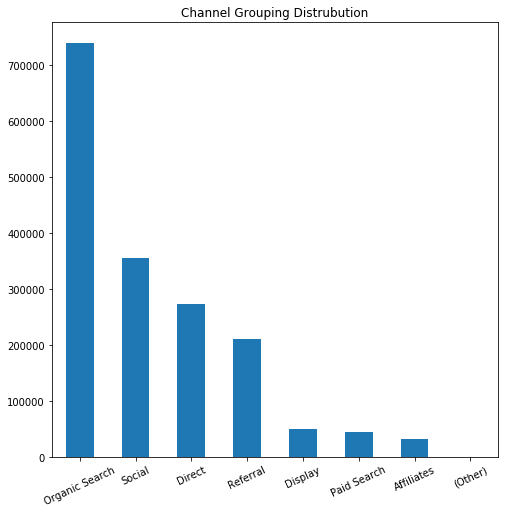

In [12]:
train['channelGrouping'].value_counts().plot(kind="bar",title="Channel Grouping Distrubution",figsize=(8,8),rot=25)

In [13]:
train['socialEngagementType'].value_counts()

Not Socially Engaged    1708337
Name: socialEngagementType, dtype: int64

In [14]:
train.head(1)[["date","visitStartTime"]]

,date,visitStartTime
0,20171016,1508198450


### Data Cleaning

In [ ]:
train["date"]=pd.to_datetime(train["date"],format="%Y%m%d")

In [15]:
list_of_devices = train['device'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in device attribute are:{}".format(keys)

"keys existed in device attribute are:['browser', 'browserVersion', 'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'deviceCategory']"

In [16]:
device_df = pd.DataFrame(train.device.apply(json.loads).tolist())[["browser","operatingSystem","deviceCategory","isMobile"]]
device_df.head(5)

,browser,operatingSystem,deviceCategory,isMobile
0,Firefox,Windows,desktop,False
1,Chrome,Chrome OS,desktop,False
2,Chrome,Android,mobile,True
3,Chrome,Windows,desktop,False
4,Chrome,Windows,desktop,False


In [19]:
list_of_devices = train['trafficSource'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in trafficSource attribute are:{}".format(keys)

"keys existed in trafficSource attribute are:['campaign', 'source', 'medium', 'keyword', 'adwordsClickInfo', 'referralPath', 'isTrueDirect', 'adContent', 'campaignCode']"

In [20]:
traffic_source_df = pd.DataFrame(train.trafficSource.apply(json.loads).tolist())[["keyword","medium" , "source"]]
traffic_source_df.head(5)

,keyword,medium,source
0,water bottle,organic,google
1,NaN,referral,sites.google.com
2,NaN,(none),(direct)
3,(not provided),organic,google
4,(not provided),organic,google


In [21]:
list_of_devices = train['geoNetwork'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in geoNetwork attribute are:{}".format(keys)

"keys existed in geoNetwork attribute are:['continent', 'subContinent', 'country', 'region', 'metro', 'city', 'cityId', 'networkDomain', 'latitude', 'longitude', 'networkLocation']"

In [22]:
geo_df = pd.DataFrame(train.geoNetwork.apply(json.loads).tolist())[["continent","subContinent","country","city"]]
geo_df.head(5)

,continent,subContinent,country,city
0,Europe,Western Europe,Germany,not available in demo dataset
1,Americas,Northern America,United States,Cupertino
2,Americas,Northern America,United States,not available in demo dataset
3,Asia,Western Asia,Turkey,not available in demo dataset
4,Americas,Central America,Mexico,not available in demo dataset


In [17]:
list_of_devices = train['totals'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in totals attribute are:{}".format(keys)

"keys existed in totals attribute are:['visits', 'hits', 'pageviews', 'bounces', 'newVisits', 'sessionQualityDim', 'timeOnSite', 'transactions', 'transactionRevenue', 'totalTransactionRevenue']"

In [18]:
totals_df = pd.DataFrame(train.totals.apply(json.loads).tolist())[["transactionRevenue", "newVisits", "bounces", "pageviews", "hits"]]
totals_df.head(5)

,transactionRevenue,newVisits,bounces,pageviews,hits
0,NaN,1,1,1,1
1,NaN,NaN,NaN,2,2
2,NaN,1,NaN,2,2
3,NaN,1,NaN,2,2
4,NaN,1,NaN,2,2


### Data Visualization

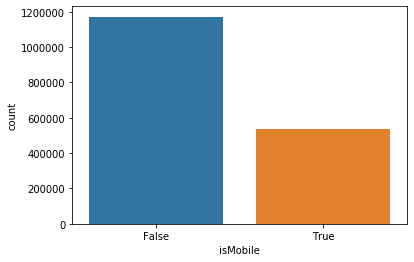

In [23]:
sns.countplot(device_df['isMobile'])

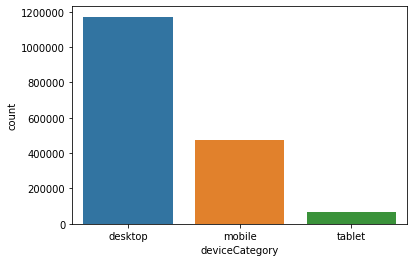

In [24]:
sns.countplot(device_df['deviceCategory'])

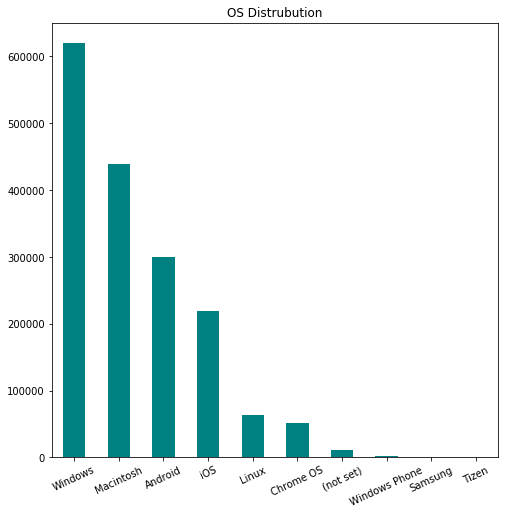

In [25]:
device_df['operatingSystem'].value_counts().head(10).plot(kind="bar",title="OS Distrubution",figsize=(8,8),rot=25,color='teal')

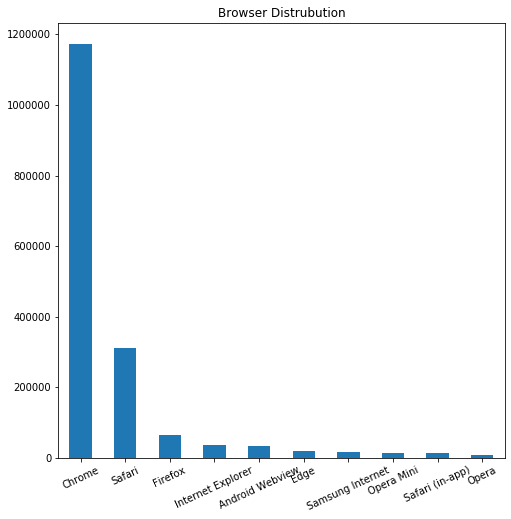

In [26]:
device_df['browser'].value_counts().head(10).plot(kind="bar",title="Browser Distrubution",figsize=(8,8),rot=25)

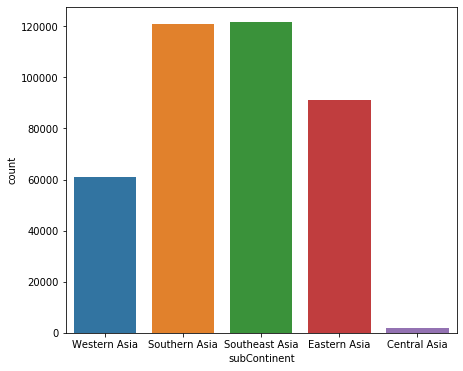

In [27]:
plt.subplots(figsize=(7, 6))
sns.countplot(geo_df[geo_df['continent']== "Asia"]['subContinent'])

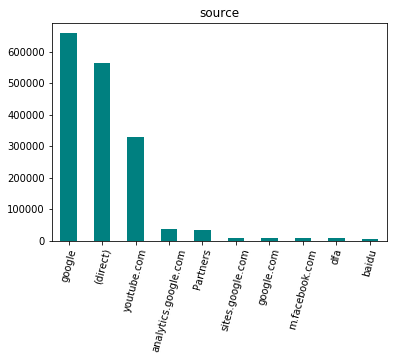

In [29]:
traffic_source_df["source"].value_counts().head(10).plot(kind="bar",title="source",rot=75,color="teal")

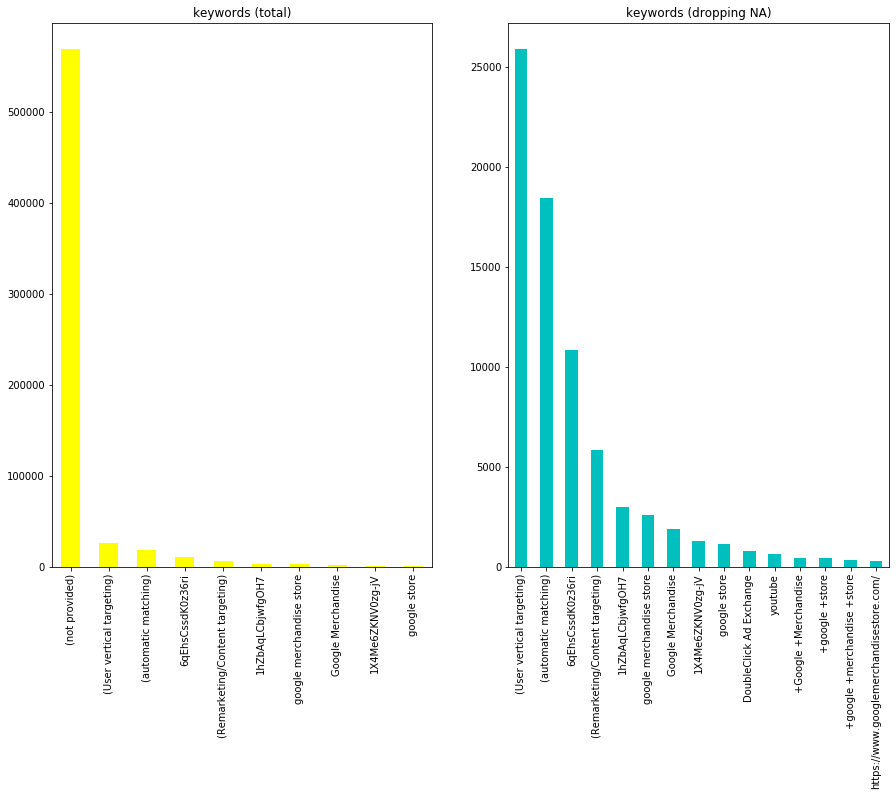

In [30]:
fig,axes = plt.subplots(1,2,figsize=(15,10))
traffic_source_df["keyword"].value_counts().head(10).plot(kind="bar",ax=axes[0], title="keywords (total)",color="yellow")
traffic_source_df[traffic_source_df["keyword"] != "(not provided)"]["keyword"].value_counts().head(15).plot(kind="bar",ax=axes[1],title="keywords (dropping NA)",color="c")

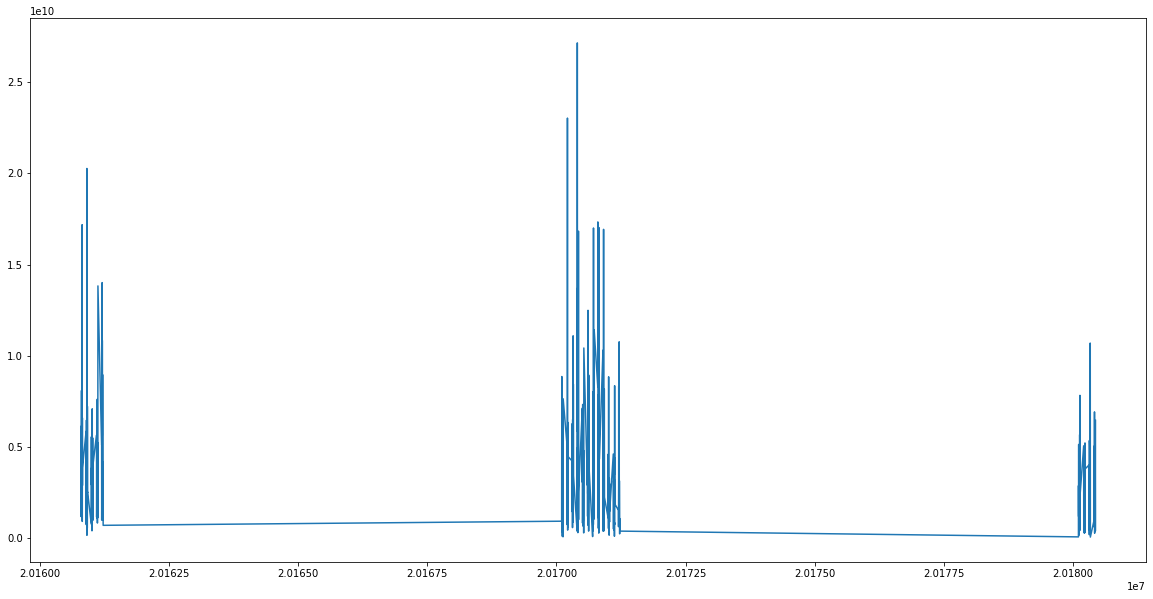

In [31]:
train["revenue"] = pd.DataFrame(train.totals.apply(json.loads).tolist())[["transactionRevenue"]]
revdat_df = train[["revenue", "date","visitNumber"]].dropna()
revdat_df["revenue"] = revdat_df.revenue.astype(np.int64)
plt.subplots(figsize=(20, 10))
plt.plot(revdat_df.groupby("date")["revenue"].sum())

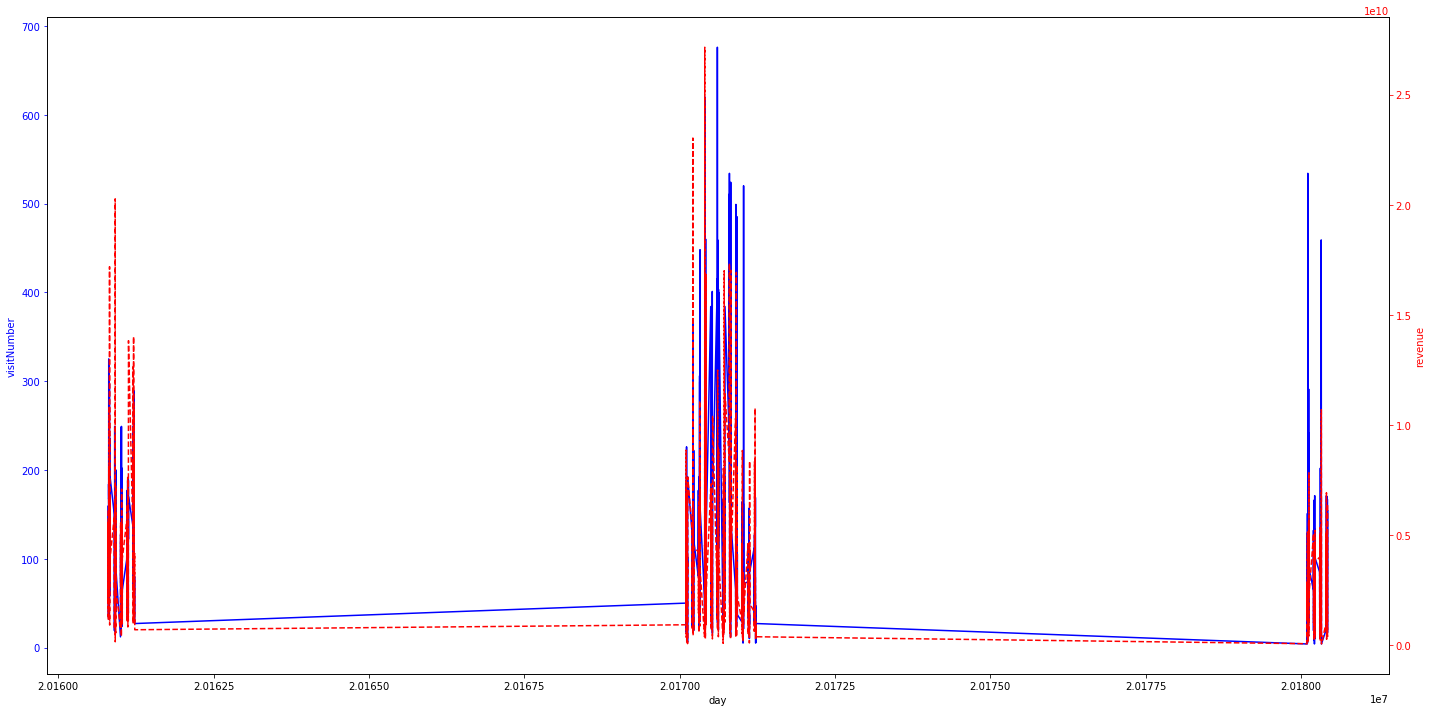

In [32]:
ab=revdat_df.groupby("date").sum()
fig, ax1 = plt.subplots(figsize=(20,10))
t = ab.index
s1 = ab["visitNumber"]
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('day')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('visitNumber', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = ab["revenue"]
ax2.plot(t, s2, 'r--')
ax2.set_ylabel('revenue', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

(array([1.30743e+06, 2.53504e+05, 7.69020e+04, 3.49070e+04, 1.81220e+04,
        8.36800e+03, 4.26100e+03, 2.85300e+03, 1.48400e+03, 5.06000e+02]),
 array([0.        , 0.61246834, 1.22493668, 1.83740502, 2.44987336,
        3.0623417 , 3.67481003, 4.28727837, 4.89974671, 5.51221505,
        6.12468339]),
 <a list of 10 Patch objects>)

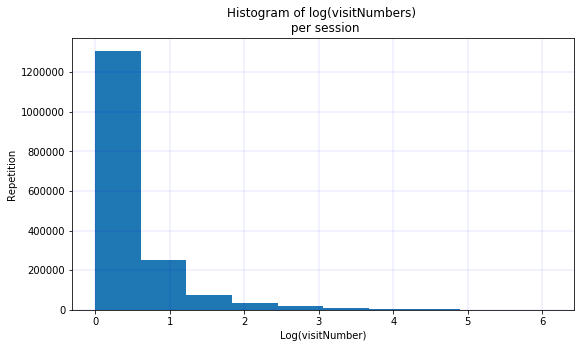

In [33]:
fig,ax = plt.subplots(figsize=(9,5))
ax.set_title("Histogram of log(visitNumbers) \n per session")
ax.set_ylabel("Repetition")
ax.set_xlabel("Log(visitNumber)")
ax.grid(color='b', linestyle='-', linewidth=0.1)
ax.hist(np.log(train['visitNumber']))

#### Most Common and Least Common

In [34]:
tmp_least_visitNumbers_list = collections.Counter(list(train.visitNumber)).most_common()[:-10-1:-1]
tmp_most_visitNumbers_list = collections.Counter(list(train.visitNumber)).most_common(10)
least_visitNumbers = []
most_visitNumbers = []
for i in tmp_least_visitNumbers_list:
    least_visitNumbers.append(i[0])
for i in tmp_most_visitNumbers_list:
    most_visitNumbers.append(i[0])
"10 most_common visitNumbers are {} times and 10 least_common visitNumbers are {} times".format(most_visitNumbers,least_visitNumbers)

'10 most_common visitNumbers are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] times and 10 least_common visitNumbers are [446, 451, 382, 409, 426, 427, 376, 377, 406, 444] times'

In [35]:
train_all=pd.concat([train.drop(["hits"],axis=1),device_df,geo_df,traffic_source_df,totals_df],axis=1)
train_all.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
revenue                 object
browser                 object
operatingSystem         object
deviceCategory          object
isMobile                  bool
continent               object
subContinent            object
country                 object
city                    object
keyword                 object
medium                  object
source                  object
transactionRevenue      object
newVisits               object
bounces                 object
pageviews               object
hits                    object
dtype: object

In [39]:
from datetime import datetime
train_all["month"] = train_all['date'].dt.month
train_all['visitHour'] = (train_all['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

AttributeError: Can only use .dt accessor with datetimelike values

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(x='month', y=train_all['transactionRevenue'].astype(np.float), data=train_all)

ValueError: Could not interpret input 'month'

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='visitHour', y=train_all['transactionRevenue'].astype(np.float), data=train_all)

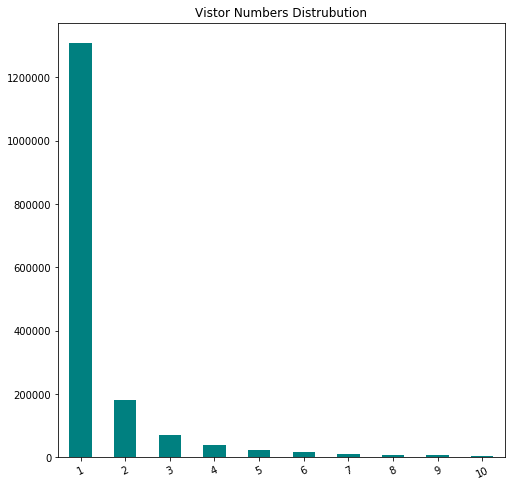

In [38]:
train_all.visitNumber.value_counts().head(10).plot(kind="bar",title="Vistor Numbers Distrubution",figsize=(8,8),rot=25,color='teal')

##### Final Dataframe

In [42]:
df_train = train_all.drop(['date','month','device','geoNetwork','trafficSource','totals','customDimensions', 'socialEngagementType', 'visitStartTime', 'visitId', 'fullVisitorId' , 'revenue'], axis=1)
df_train.dtypes

channelGrouping       object
visitNumber            int64
browser               object
operatingSystem       object
deviceCategory        object
isMobile                bool
continent             object
subContinent          object
country               object
city                  object
keyword               object
medium                object
source                object
transactionRevenue    object
newVisits             object
bounces               object
pageviews             object
hits                  object
dtype: object

In [43]:
df_train.isnull().sum().sort_values(ascending=False)

transactionRevenue    1689823
keyword               1052780
bounces                836759
newVisits              400907
pageviews                 239
hits                        0
isMobile                    0
visitNumber                 0
browser                     0
operatingSystem             0
deviceCategory              0
country                     0
continent                   0
subContinent                0
city                        0
medium                      0
source                      0
channelGrouping             0
dtype: int64

In [44]:
df_train=df_train.fillna(0)

numerical_features = ['transactionRevenue','visitNumber', 'newVisits', 'bounces', 'pageviews', 'hits']

for col in numerical_features:
    df_train[col] = df_train[col].astype(np.float)

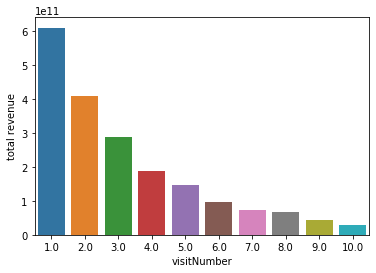

In [45]:
vst_rev=df_train.groupby('visitNumber')['transactionRevenue'].agg(['count','mean','sum'])
vst_rev.columns = ["count", "mean transaction","total revenue"]
vst_rev = vst_rev.sort_values(by="count", ascending=False)
sns.barplot(y=vst_rev['total revenue'].head(10),x=vst_rev.index[:10])

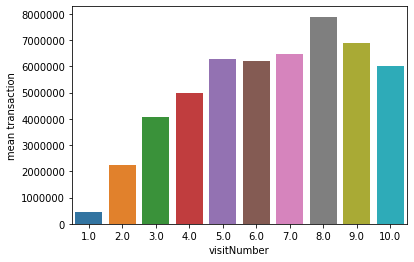

In [46]:
sns.barplot(y=vst_rev['mean transaction'].head(10),x=vst_rev.index[:10])

In [47]:
def feat_plot(col):
    pt = df_train.loc[:,[col, 'transactionRevenue']]
    feat_vis=pt.groupby(col)['transactionRevenue'].agg(['count','mean'])
    feat_vis.columns = ["count", "mean transaction value"]
    feat_vis['total_revenue'] = feat_vis['count']*feat_vis['mean transaction value']
    feat_vis = feat_vis.sort_values(by="count", ascending=False)
    plt.figure(figsize=(8, 16)) 
    plt.subplot(2,1,1)
    sns.barplot(x=feat_vis['count'].head(10), y=feat_vis.index[:10])
    plt.subplot(2,1,2)
    sns.barplot(x=feat_vis['mean transaction value'].head(10), y=feat_vis.index[:10])

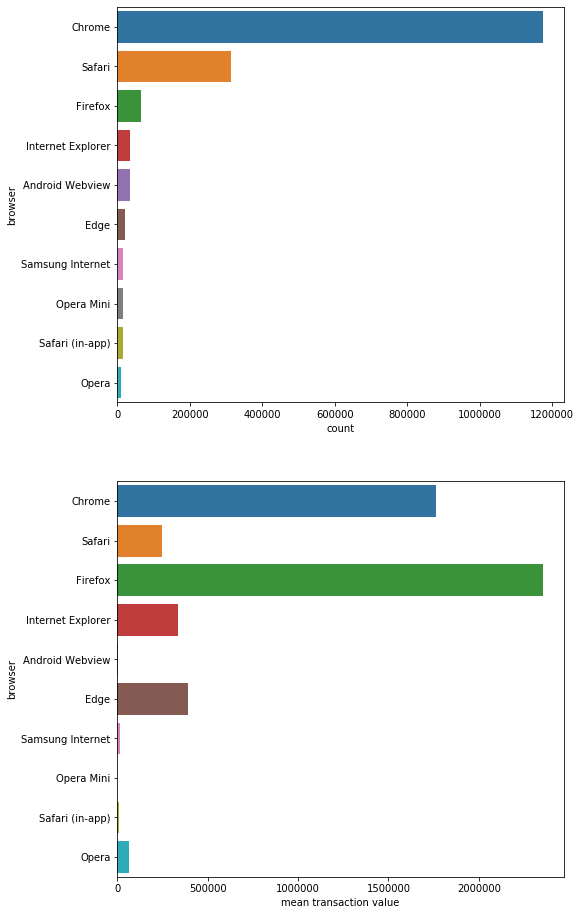

In [48]:
feat_plot('browser')

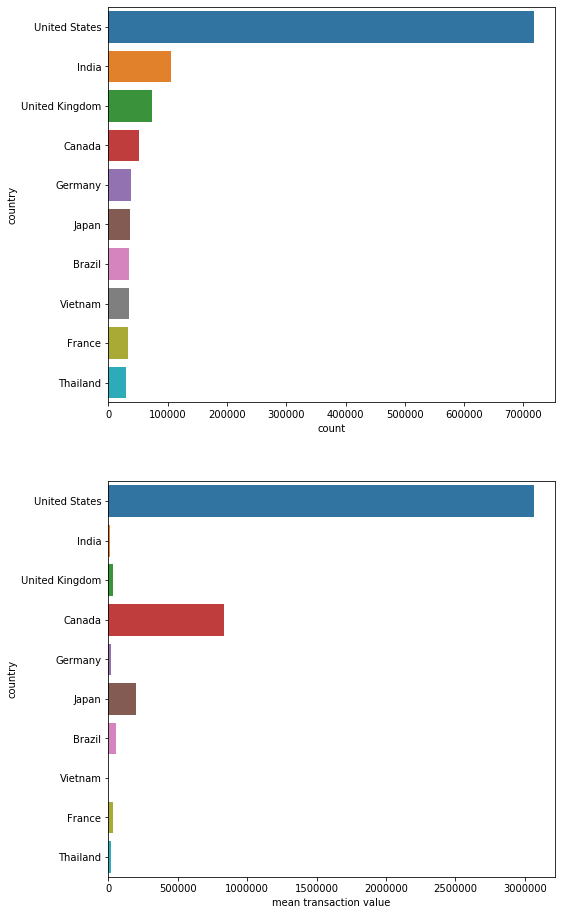

In [50]:
feat_plot('country')

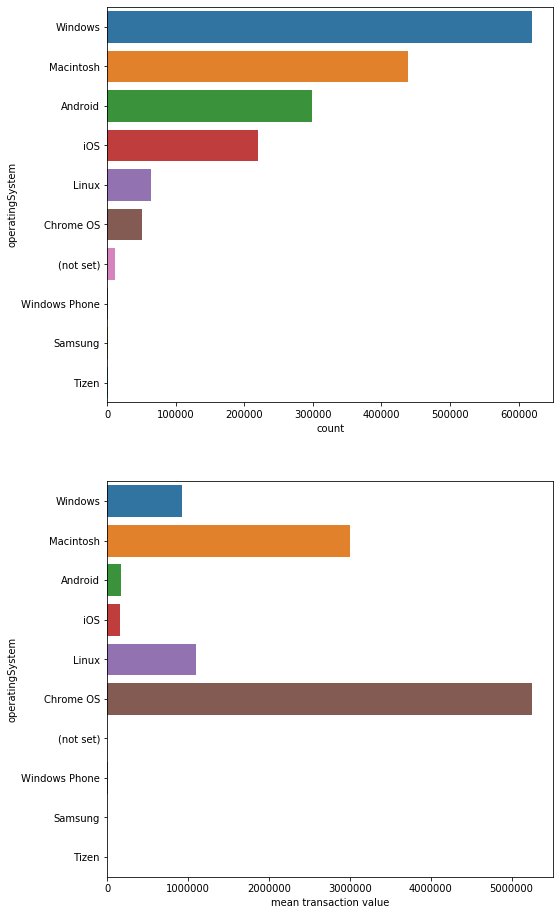

In [49]:
feat_plot('operatingSystem')

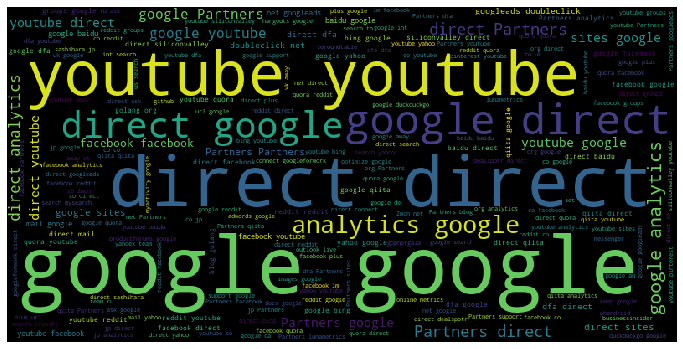

In [51]:
from wordcloud import WordCloud
source = df_train['source']
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(source))
plt.figure( figsize=(12,10) )
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [52]:
categorical_features = ['channelGrouping', 'browser', 'operatingSystem', 'deviceCategory', 'isMobile',
                        'continent', 'subContinent', 'country', 'city', 'keyword', 'medium', 'source']    

for col in categorical_features:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))


### Light Gradient Boosting Model

In [53]:
X=df_train.drop(['transactionRevenue'], axis=1)
y=np.log1p(df_train['transactionRevenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [54]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7, 
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }


lgtrain = lgbm.Dataset(X_train, label=y_train)
lgval = lgbm.Dataset(X_test, label=y_test)
lgb_model = lgbm.train(params, lgtrain, valid_sets=[lgval], num_boost_round=2000, early_stopping_rounds=100, verbose_eval=100)
pred_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.54407
[200]	valid_0's rmse: 1.53636
[300]	valid_0's rmse: 1.53494
Early stopping, best iteration is:
[294]	valid_0's rmse: 1.53464


In [ ]:
fig, ax = plt.subplots(figsize=(8,12))
lgbm.plot_importance(lgb_model, max_num_features=30, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
grid= {"min_child_weight":[4,5,6],"max_depth":[-1,1,3,5], "learning_rate":[0.1,0.01,0.2]}
lgb=LGBMRegressor(random_state=96,objective='regression',metric='rmse')
gridsearch= GridSearchCV(lgb,param_grid=grid,cv=5)
gridsearch.fit(X_train, y_train)
print(gridsearch.best_score_)
print(gridsearch.best_params_)

In [ ]:
lgb= LGBMRegressor(objective='regression',metric='rmse',learning_rate=0.1,min_child_weight=4)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
accuracy = lgb.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

In [ ]:
mean_absolute_error(y_test, lgb_pred)

In [ ]:
mean_squared_error(y_test, lgb_pred)

In [ ]:
np.sqrt(mean_squared_error(y_test, lgb_pred))

In [ ]:
coefs = pd.Series(lgb.feature_importances_, index = X_train.columns)
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.xlabel("LGB coefficient", weight='bold')
plt.title("Feature importance in the LightGB Model", weight='bold')
plt.show()